In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - (t**2)) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # topological sort algo (copy pasted from wiki)

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [31]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # LR -> Left to Right
    nodes, edges = trace(root)

    for n in nodes:
        uid =  str(id(n))
        # for any value in the graph, crate a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  
    

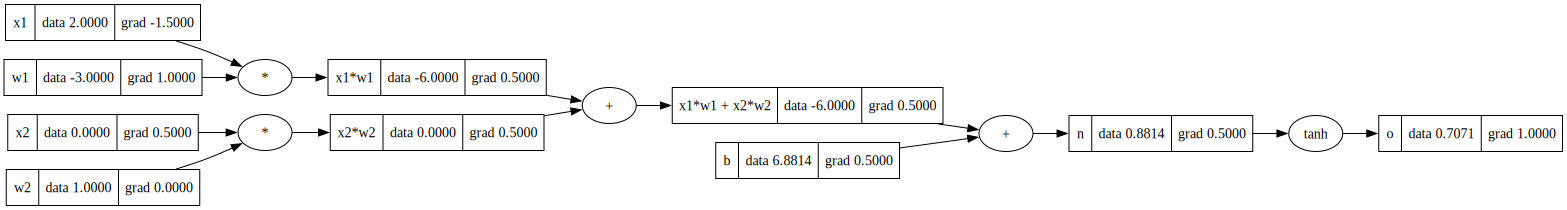

In [99]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# neuron bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

o.backward()
draw_dot(o)

In [228]:
import random

In [838]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # (w dot x) + b
        act = sum((xi*wi for xi,wi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neuron = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neuron]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neuron for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layer = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layer:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layer for p in layer.parameters()]

In [839]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.161623193658823)

In [840]:
# example dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0 -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.161623193658823),
 Value(data=0.9652327652772477),
 Value(data=0.9515139468205547),
 Value(data=0.9015234597375507)]

In [841]:
loss = sum(((yout - ygd)**2 for ygd, yout in zip(ys, ypred)), Value(0.0))
loss

Value(data=8.38311980474729)

In [842]:
step_size = 0.01
losses = []
for k in range(1000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygd)**2 for ygd, yout in zip(ys, ypred)), Value(0.0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    if loss.data < 1.0:
        step_size = 0.005

    if loss.data < 0.01:
        step_size = 0.0005
    # update
    for p in n.parameters():
        p.data += -step_size * p.grad

    losses.append(loss.data)

    #print(k, loss.data)
print(k, loss.data)

999 0.012798133812746287


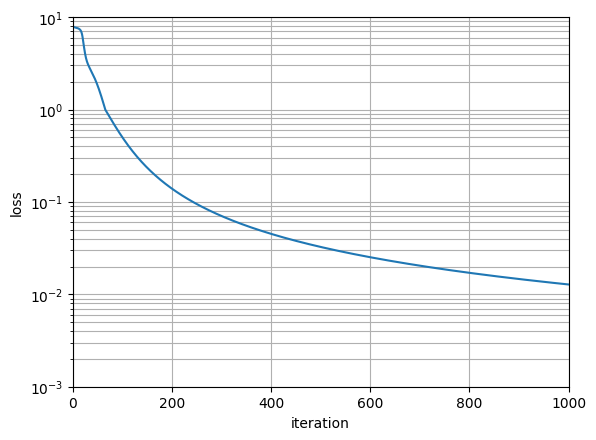

In [843]:

plt.figure()
plt.plot(losses)
plt.yscale("log")
plt.ylim(1e-3, 10)   # <-- manually set range
plt.xlim(0, 1000)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.grid(True, which="both")
plt.show()